In [1]:
# !pip install plotly pandas
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.autograd import Variable

**1) Data loading and pre processing**

In [2]:
# Load Historical stock data
def load_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

In [44]:
# Define a function to preprocess the data
def preprocess_data(data):
    # Extract the closing prices
    prices = data['Close'].values.astype(float)
    print(f'Before scaling prices: \n {prices} \n \nAfter scaling:')
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    prices = scaler.fit_transform(prices.reshape(-1, 1))

    return prices, scaler

In [4]:
# Create sequences for training the Model
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        label = data[i+seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)


**2) Model structure**

In [5]:
# Define the StockForecasting model
class StockForecastingLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockForecastingLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

**3) Hyperparameters setting**



In [6]:
# Define hyperparameters (maybe the user could pass some of these: symbol, start_date, end_date, seq_length...) TRY IT
symbol = 'AAPL'
start_date = '2010-01-01'
end_date = '2023-09-21'
seq_length = 5 # days picked
input_size = 1 # one value per row (closing price)
hidden_size = 64
num_layers = 2 # 2 layers of the LSTM
output_size = 1
num_epochs = 150
learning_rate = 0.001
dropout_prob = 0.5

In [7]:
data = load_stock_data(symbol, start_date, end_date)
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.487534,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.498751,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.395379,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.383556,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.425996,447610800
...,...,...,...,...,...,...
2023-09-14,174.000000,176.100006,173.580002,175.740005,175.740005,60895800
2023-09-15,176.479996,176.500000,173.820007,175.009995,175.009995,109205100
2023-09-18,176.479996,179.380005,176.169998,177.970001,177.970001,67257600


In [8]:
# Get the last day
last_date = data.index[-1]
print(f'The last date is: {last_date}')

The last date is: 2023-09-20 00:00:00


In [9]:
# Function to get only the week day (not weekend)
def get_next_weekday_date(date):
    while date.weekday() >= 5:  # Check if the date is Saturday (5) or Sunday (6)
        date += datetime.timedelta(days=1)  # Move to the next day
    return date

In [10]:
# Get the next day
tomorrow_date = get_next_weekday_date(last_date + datetime.timedelta(days=1))
print(f'The next date is: {tomorrow_date}')

The next date is: 2023-09-21 00:00:00


In [11]:
# Get only the closing price and scale it
prices, scaler = preprocess_data(data)
prices

Before scaling prices: 
 [  7.64321423   7.65642881   7.53464317 ... 177.97000122 179.07000732
 175.49000549] 
 
After scaling:


array([[0.00413672],
       [0.00420642],
       [0.00356406],
       ...,
       [0.90252708],
       [0.90832907],
       [0.88944631]])

In [12]:
# Create sequences for training
sequences, target = create_sequences(prices, seq_length)
print(f'{sequences.shape} | {target.shape}')

(3447, 5, 1) | (3447, 1)


In [13]:
# The sequence is 5 days (last 5 days)
sequences[-1]

array([[0.88269495],
       [0.89076494],
       [0.88691449],
       [0.90252708],
       [0.90832907]])

In [14]:
# Target is the next day of the sequence (in a sequence of 5 days it'll be the 6th)
# In this case the last day of the historical data
target[-1]

array([0.88944631])

In [15]:
# Convert sequences and target to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sequences = torch.from_numpy(sequences).float().to(device)
target = torch.from_numpy(target).float().to(device)

**4) Train and Test splitting**

In [16]:
# Split the data into training and testing sets
# Try to change the split many times to get the better one (as performance)
train_size = int(len(sequences) * 0.85)
train_seq = sequences[:train_size]
train_target = target[:train_size]
test_seq = sequences[train_size:]
test_target = target[train_size:]

In [17]:
train_seq.shape

torch.Size([2929, 5, 1])

In [18]:
train_target.shape

torch.Size([2929, 1])

In [19]:
test_seq.shape

torch.Size([518, 5, 1])

In [20]:
test_target.shape

torch.Size([518, 1])

In [21]:
# Create Dataset and DataLoader objects
batch_size = 64
train_data = torch.utils.data.TensorDataset(train_seq, train_target)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [22]:
# Initialize the Model
model = StockForecastingLSTM(input_size, hidden_size, num_layers, output_size).to(device)

**5) Loss and Optimizer**

In [23]:
# Loss and optimizer
criterion = nn.MSELoss() # because of regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**6) Training**

In [24]:
# Training the model
losses = []
epochs = []
for epoch in range(num_epochs):
    for batch_seq, batch_target in train_loader:
        batch_seq = batch_seq.to(device)
        batch_target = batch_target.to(device)

        # Forward pass
        outputs = model(batch_seq)
        loss = criterion(outputs, batch_target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')
        epochs.append(epoch+1)
        losses.append(loss.item())

Epoch [5/150], Loss: 0.000132
Epoch [10/150], Loss: 0.000125
Epoch [15/150], Loss: 0.000077
Epoch [20/150], Loss: 0.000113
Epoch [25/150], Loss: 0.000067
Epoch [30/150], Loss: 0.000104
Epoch [35/150], Loss: 0.000043
Epoch [40/150], Loss: 0.000123
Epoch [45/150], Loss: 0.000024
Epoch [50/150], Loss: 0.000079
Epoch [55/150], Loss: 0.000075
Epoch [60/150], Loss: 0.000092
Epoch [65/150], Loss: 0.000081
Epoch [70/150], Loss: 0.000050
Epoch [75/150], Loss: 0.000041
Epoch [80/150], Loss: 0.000056
Epoch [85/150], Loss: 0.000042
Epoch [90/150], Loss: 0.000096
Epoch [95/150], Loss: 0.000021
Epoch [100/150], Loss: 0.000045
Epoch [105/150], Loss: 0.000048
Epoch [110/150], Loss: 0.000092
Epoch [115/150], Loss: 0.000069
Epoch [120/150], Loss: 0.000077
Epoch [125/150], Loss: 0.000042
Epoch [130/150], Loss: 0.000063
Epoch [135/150], Loss: 0.000059
Epoch [140/150], Loss: 0.000017
Epoch [145/150], Loss: 0.000012
Epoch [150/150], Loss: 0.000048


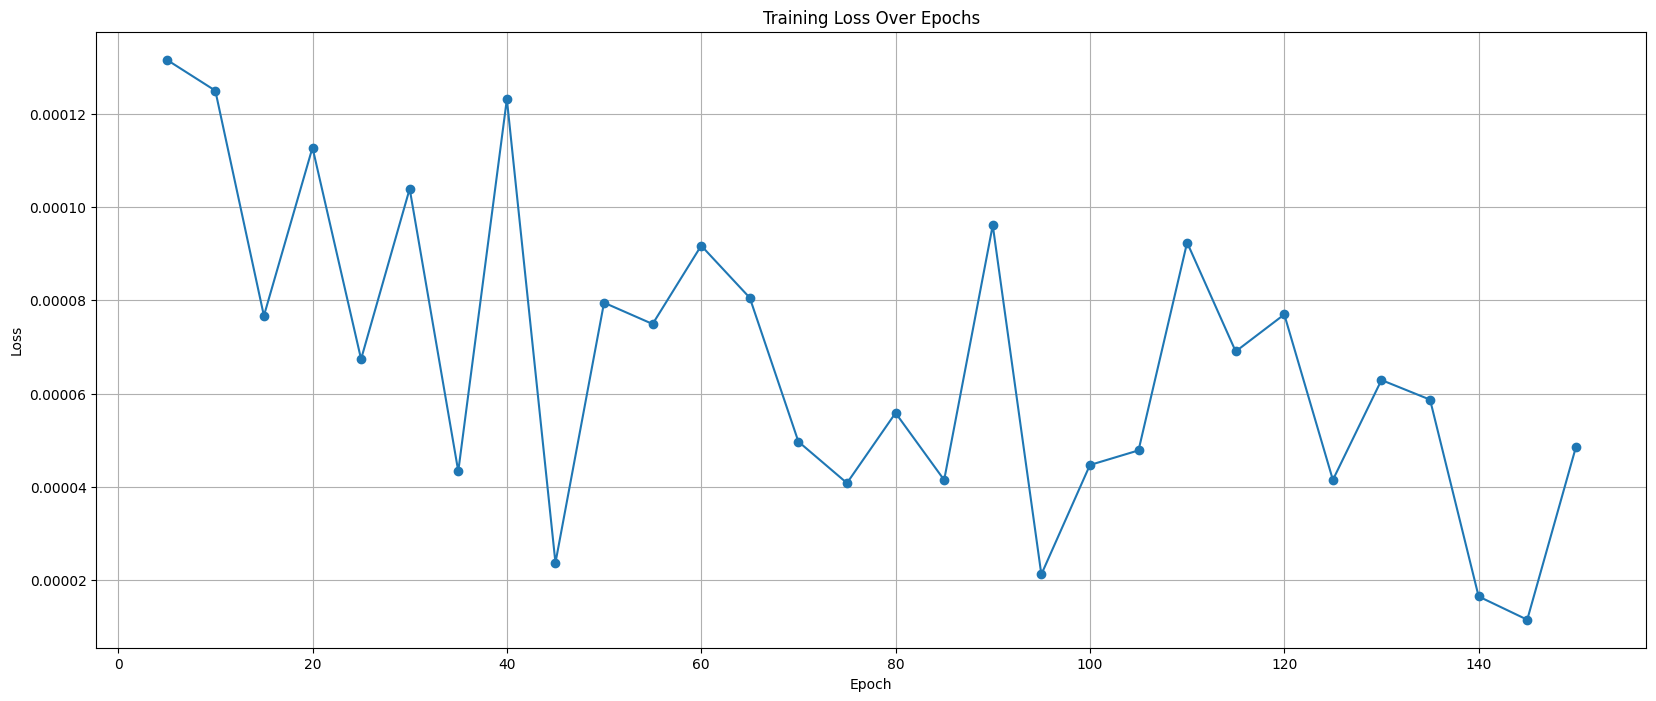

In [25]:
# Plot the loss values
plt.figure(figsize=(20, 8))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

**7) Evaluation**

In [26]:
# Evaluate the model
model.eval()
test_seq = Variable(test_seq)
with torch.no_grad():
    predicted = model(test_seq).cpu().numpy()
    predicted = scaler.inverse_transform(predicted)
    true = scaler.inverse_transform(test_target.cpu().numpy())

In [27]:
# Calculate regression metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(true, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(true, predicted)
r2 = r2_score(true, predicted)
print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R^2): {r2:.4f}')

Mean Squared Error (MSE): 8.7010
Root Mean Squared Error (RMSE): 2.9497
Mean Absolute Error (MAE): 2.2641
R-squared (R^2): 0.9661


**7.1) ACCURACY for next day sell or buy**

In [43]:
# ACCURACY for next day sell or buy

real_acc_buy = []
pred_acc_buy = []

for i in range(0, true.shape[0]-1):
  count = count + 1
  if true[i+1]-true[i] > 0:
    # Buy
    real_acc_buy.append(True)
  else:
    # Sell
    real_acc_buy.append(False)

  if predicted[i+1]-true[i] > 0:
    # Buy
    pred_acc_buy.append(True)
  else:
    # Sell
    pred_acc_buy.append(False)

right_pred = 0
for i in range(0, len(real_acc_buy)):
  if(real_acc_buy[i] == pred_acc_buy[i]):
      right_pred = right_pred+1

print(f'Accuracy : {round(right_pred/len(real_acc_buy)*100, 2)}%')


Accuracy : 53.38%


**8) Plot the True and the Predicted values**

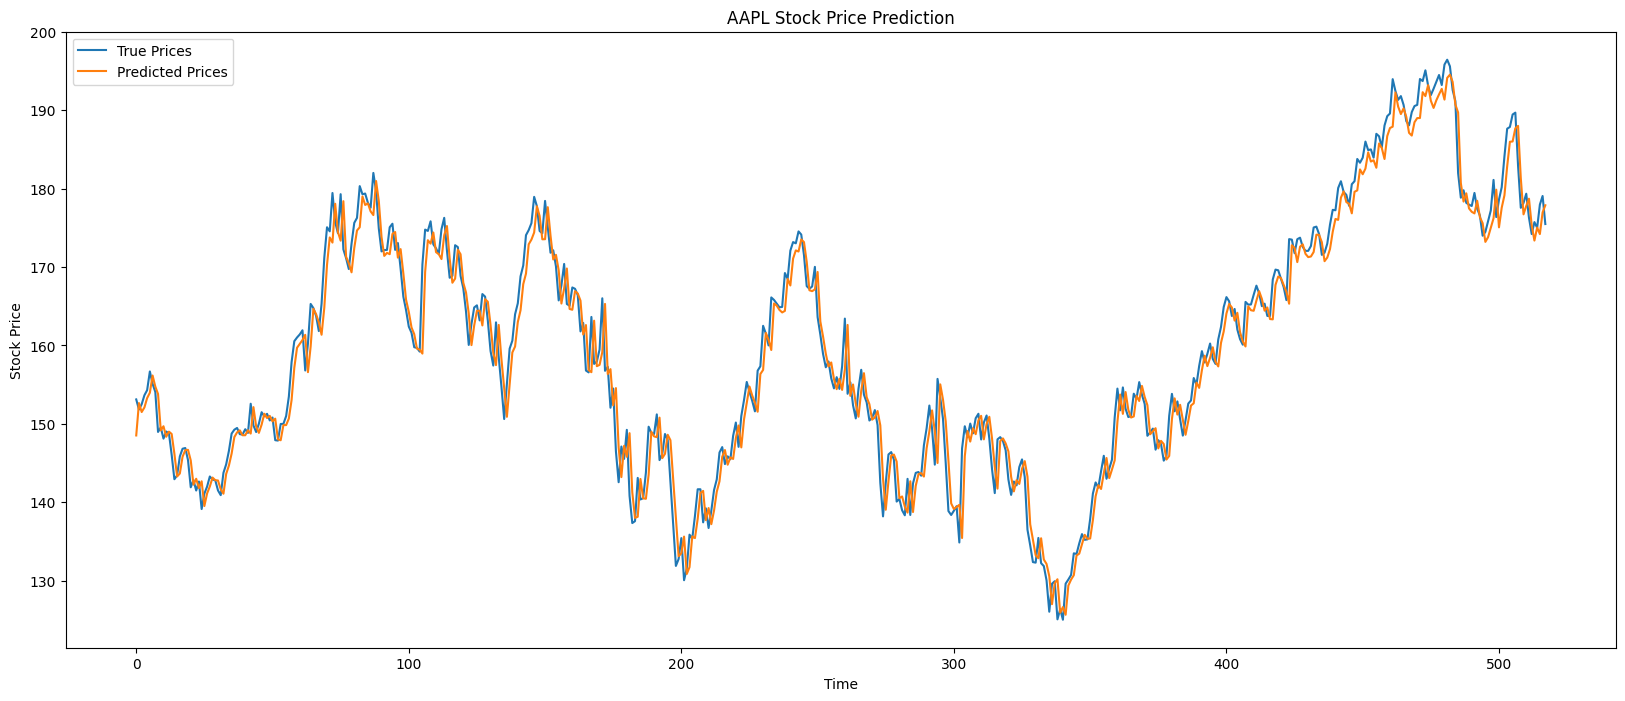

In [29]:
# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(true, label='True Prices')
plt.plot(predicted, label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction')
plt.show()

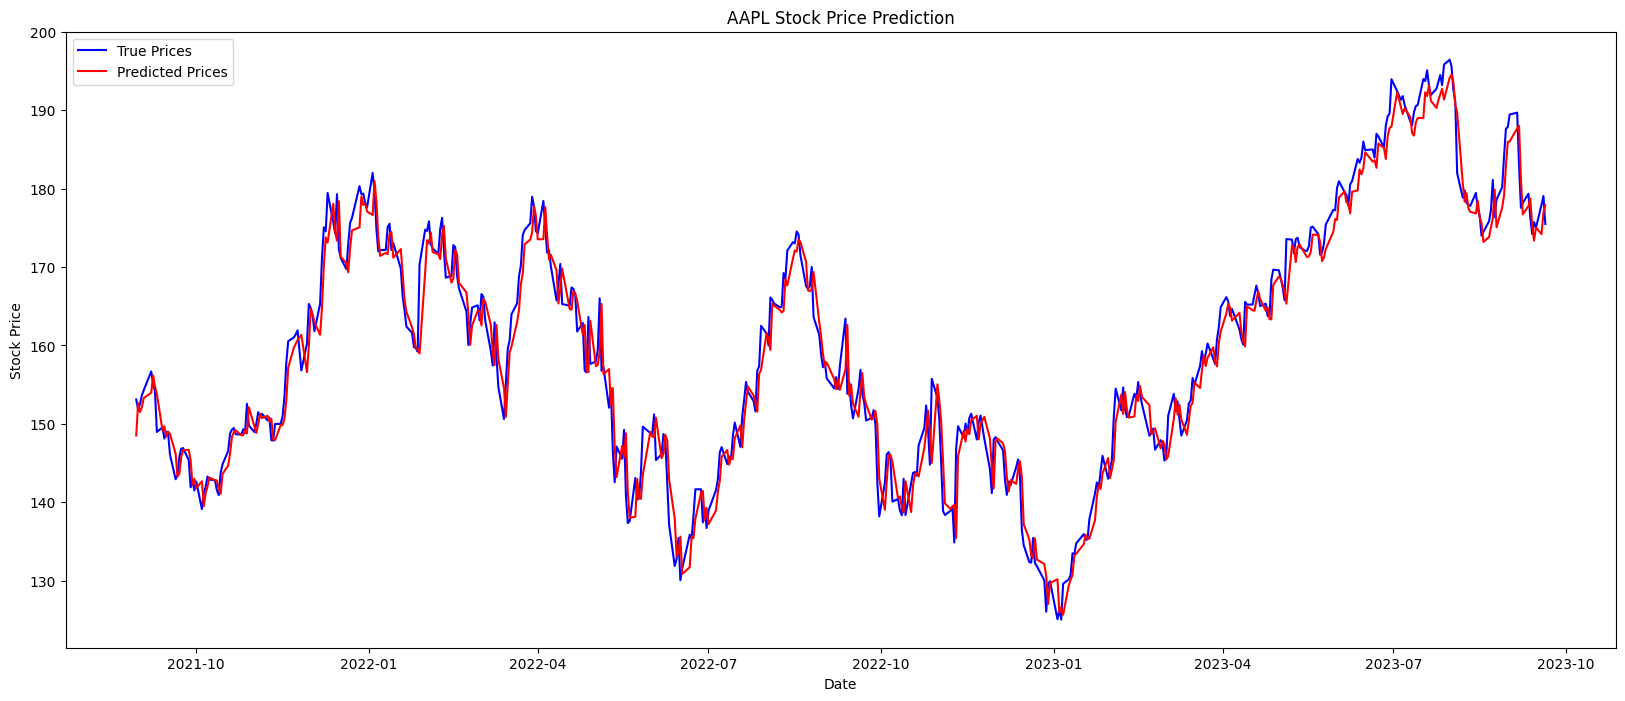

In [30]:
plt.figure(figsize=(20, 8))
plt.plot(data.index[-len(true):], true, label='True Prices', color='blue')
plt.plot(data.index[-len(predicted):], predicted, label='Predicted Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction')
plt.show()

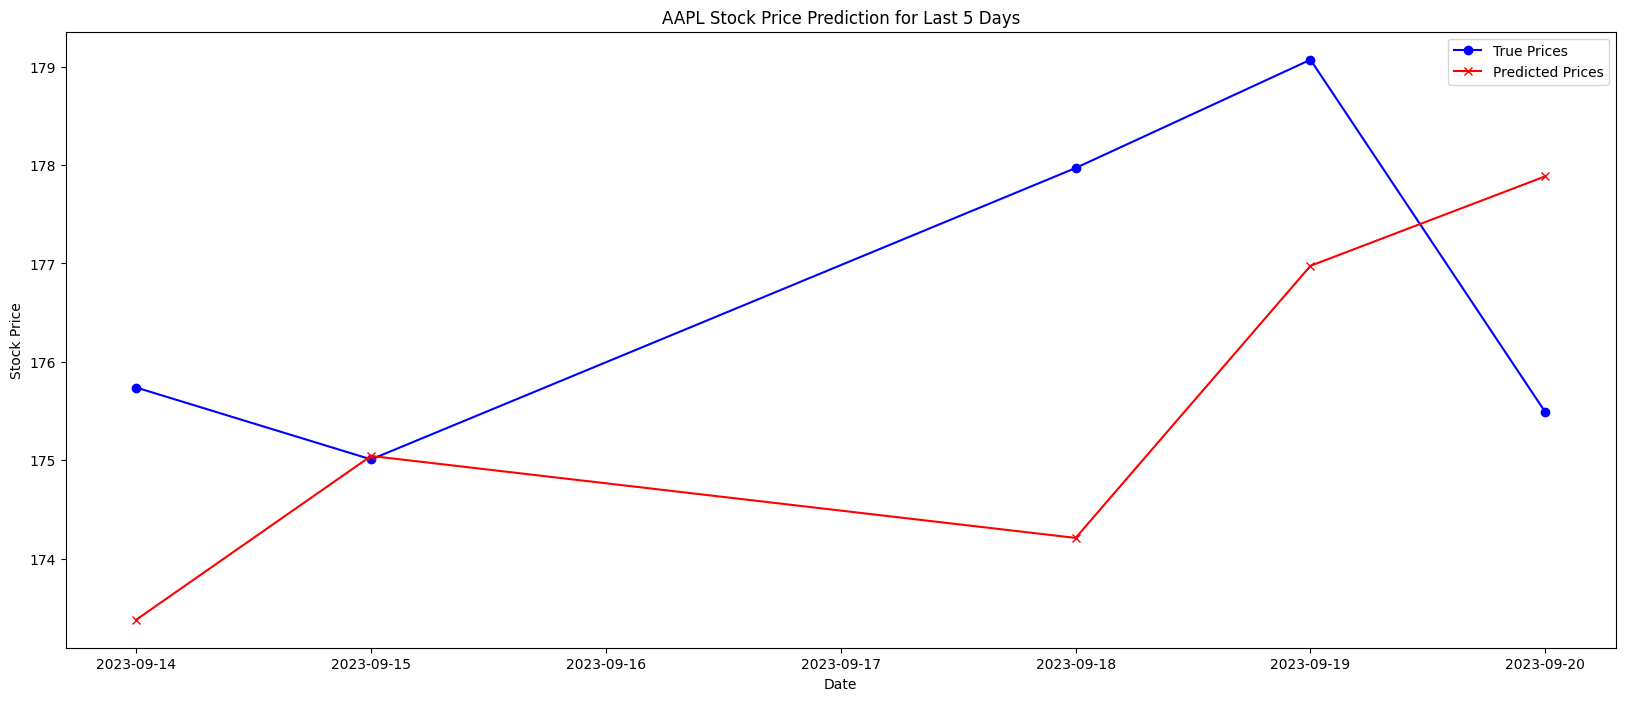

In [45]:
horizon = 5  # The sequence length as days to predict the next one
plt.figure(figsize=(20, 8))
plt.plot(data.index[-horizon:], true[-horizon:], label='True Prices', color='blue', marker='o')
plt.plot(data.index[-horizon:], predicted[-horizon:], label='Predicted Prices', color='red', marker='x')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction for Last {horizon} Days')
plt.show()

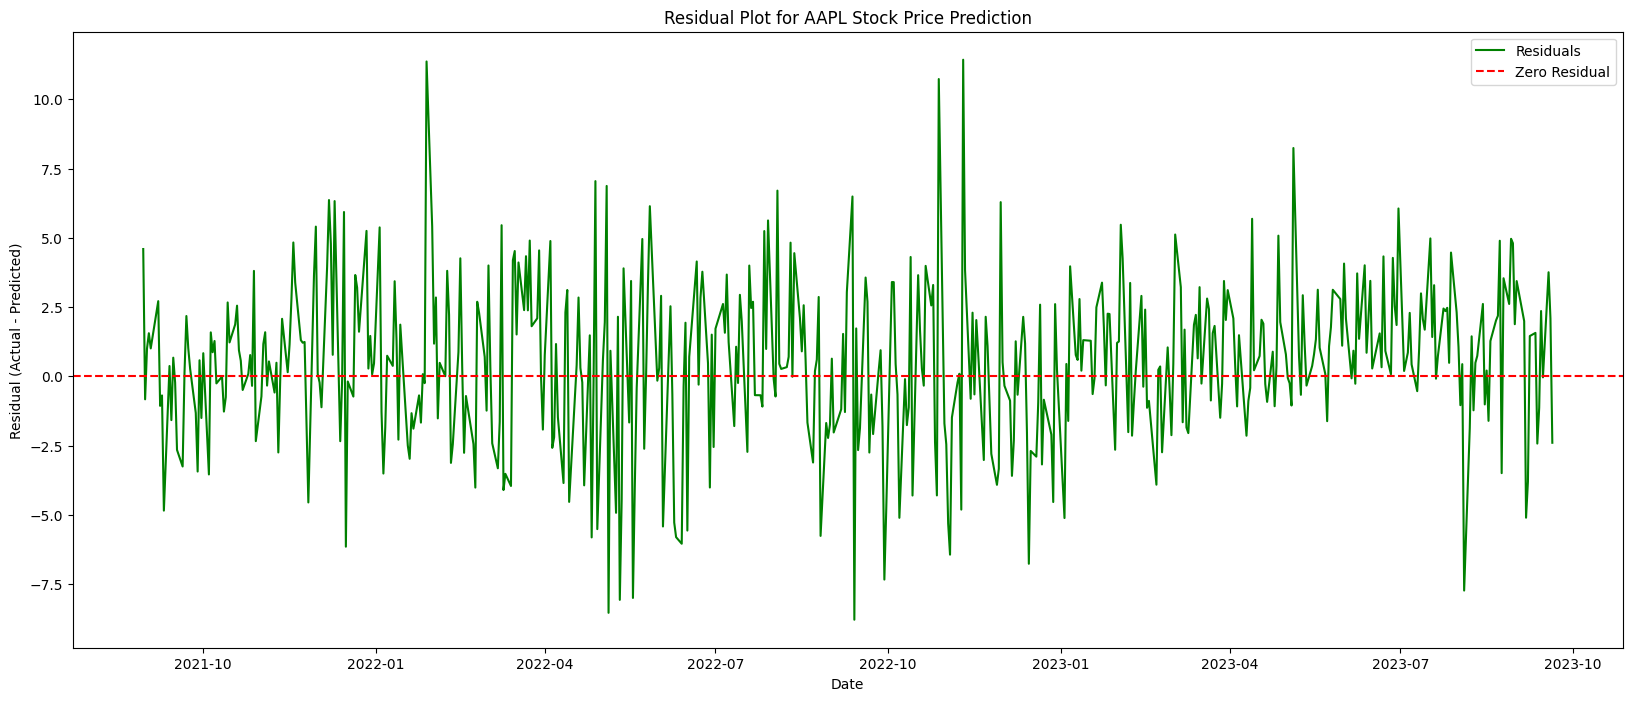

In [32]:
residuals = true - predicted
plt.figure(figsize=(20, 8))
plt.plot(data.index[-len(residuals):], residuals, label='Residuals', color='green')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Date')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.title(f'Residual Plot for {symbol} Stock Price Prediction')
plt.show()

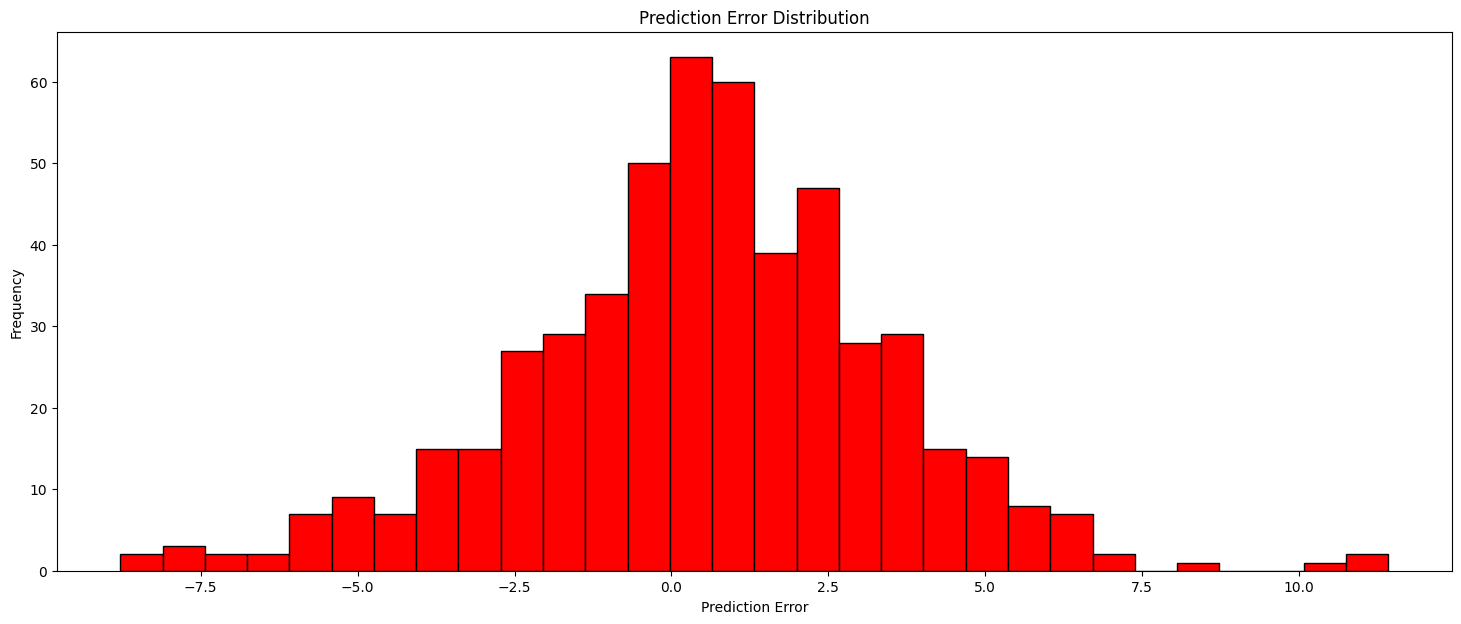

In [33]:
error = true - predicted
plt.figure(figsize=(18, 7))
plt.hist(error, bins=30, color='red', edgecolor='black')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Prediction Error Distribution')
plt.show()

**9) Next day stock price prediction**

In [34]:
# Prepare data for the prediction
last_seq = data["Close"][-seq_length:]  # Use the last 'seq_length' data points
print(last_seq)
last_seq_normalized = scaler.transform(last_seq.values.reshape(-1, 1))
last_seq_tensor = torch.from_numpy(last_seq_normalized).float().to(device)

Date
2023-09-14    175.740005
2023-09-15    175.009995
2023-09-18    177.970001
2023-09-19    179.070007
2023-09-20    175.490005
Name: Close, dtype: float64


In [35]:
# Make the prediction for the next weekday date
with torch.no_grad():
    prediction = model(last_seq_tensor.unsqueeze(0))
    prediction = scaler.inverse_transform(prediction.cpu().numpy())

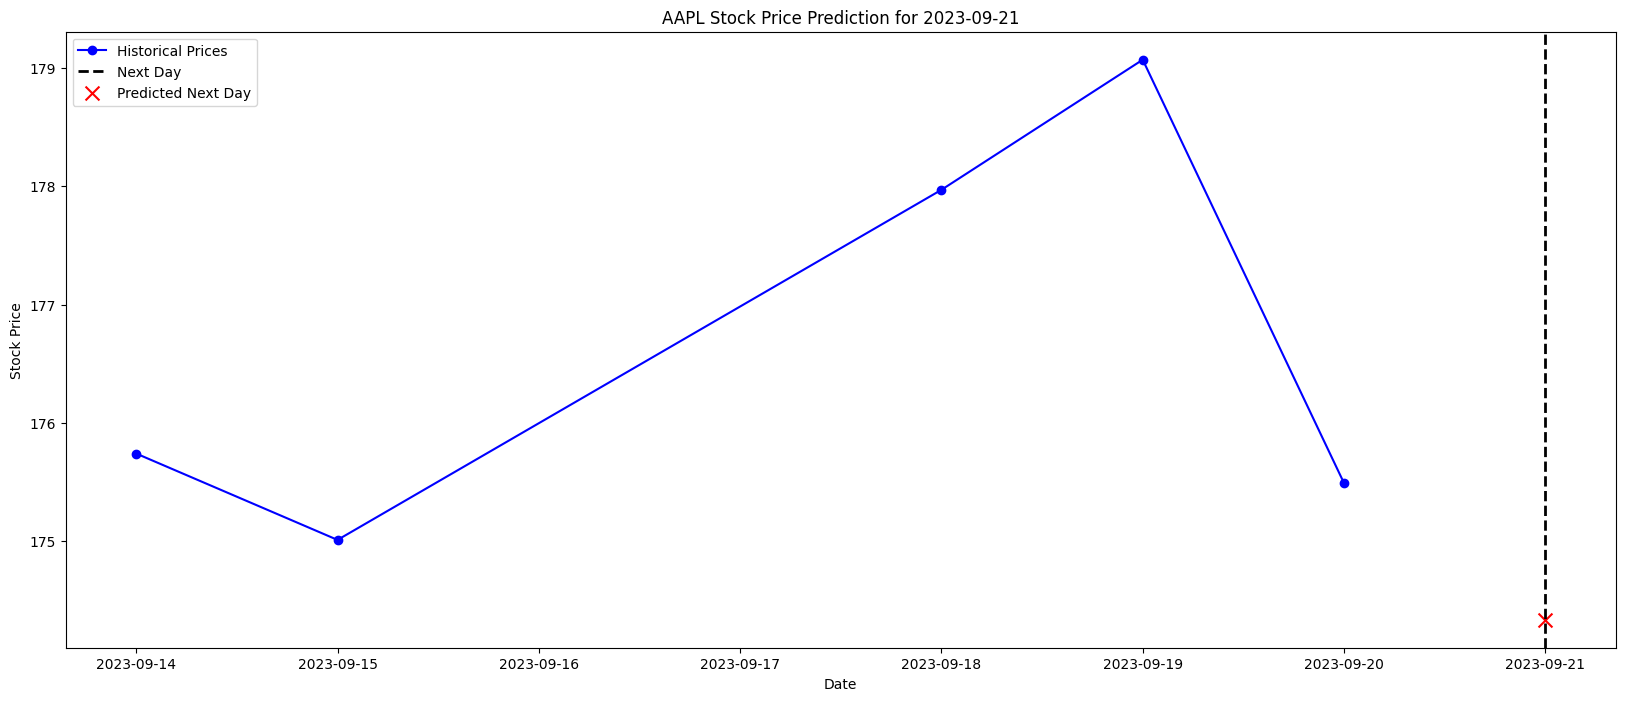

Predicted Closing Price for 2023-09-21: 174.33514404296875


In [36]:
# Plot historical prices and the predicted price for the next day
plt.figure(figsize=(20, 8))
plt.plot(data.index[-len(last_seq):], last_seq, label='Historical Prices', color='blue', marker='o')
plt.axvline(x=tomorrow_date, color='black', linestyle='--', label='Next Day', linewidth=2)
plt.scatter(tomorrow_date, prediction[0][0], color='red', marker='x', label='Predicted Next Day', s=100)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title(f'{symbol} Stock Price Prediction for {tomorrow_date.strftime("%Y-%m-%d")}')
plt.show()

# Print the predicted closing price for the next weekday
print(f"Predicted Closing Price for {tomorrow_date.strftime('%Y-%m-%d')}: {prediction[0][0]}")

In [37]:
import plotly.express as px
import plotly.graph_objects as go

# Create a DataFrame for visualization
data_vis = pd.DataFrame({'Date': data.index[-len(last_seq):], 'Price': last_seq})
data_vis['Date'] = pd.to_datetime(data_vis['Date'])

# Create a Plotly line chart
fig = px.line(data_vis, x='Date', y='Price', title=f'{symbol} Stock Price Prediction for {tomorrow_date.strftime("%Y-%m-%d")}')

# Add a vertical line for the next day
fig.add_shape(
    dict(
        type="line",
        x0=tomorrow_date,
        x1=tomorrow_date,
        y0=0,
        y1=1,
        xref="x",
        yref="paper",
        line=dict(color="black", dash="dash"),
    )
)

# Add a scatter point for the predicted next day price
fig.add_trace(
    go.Scatter(
        x=[tomorrow_date],
        y=[prediction[0][0]],
        mode='markers',
        name="Predicted Next Day",
        marker=dict(color="red", size=10)
    )
)

fig.show()

# Print the predicted closing price for the next weekday
print(f"Predicted Closing Price for {tomorrow_date.strftime('%Y-%m-%d')}: {prediction[0][0]}")

Predicted Closing Price for 2023-09-21: 174.33514404296875


**9.1) For Tomorrow: "Sell or Buy"?**

In [38]:
import plotly.graph_objects as go

# Calculate the predicted next day closing price
predicted_next_day_price = prediction[0][0]

# Calculate the difference between the predicted next day and the current day closing prices
current_day_price = data_vis['Price'].iloc[-1]
price_difference = predicted_next_day_price - current_day_price

# Create a Plotly figure
fig = go.Figure()

# Add a trace for the stock price
fig.add_trace(go.Scatter(x=data_vis['Date'], y=data_vis['Price'], mode='lines', name='Stock Price'))

# Add a trace for the predicted next day price
fig.add_trace(go.Scatter(x=[tomorrow_date], y=[predicted_next_day_price],
                         mode='markers', name='Predicted Next Day Price',
                         marker=dict(color="red", size=10)))

# Create a text annotation for the predicted price
fig.add_annotation(
    x=tomorrow_date, y=predicted_next_day_price, text=f'Predicted: ${predicted_next_day_price:.2f}',
    showarrow=True, arrowhead=1, ax=0, ay=-30, font=dict(size=12, color='red')
)

# Create a text annotation for the current price
fig.add_annotation(
    x=data_vis['Date'].iloc[-1], y=current_day_price, text=f'Current: ${current_day_price:.2f}',
    showarrow=True, arrowhead=1, ax=0, ay=-30, font=dict(size=12)
)

# Add a vertical line for the next day
fig.add_shape(
    dict(
        type="line",
        x0=tomorrow_date,
        x1=tomorrow_date,
        y0=data_vis['Price'].min(),
        y1=data_vis['Price'].max(),
        xref="x",
        yref="y",
        line=dict(color="black", dash="dash"),
    )
)

# Update layout
fig.update_layout(
    title=f'{symbol} Stock Price Prediction for {tomorrow_date.strftime("%Y-%m-%d")}',
    xaxis_title='Date',
    yaxis_title='Price',
)

# Make a buy/sell recommendation based on the price difference
recommendation = "Buy" if price_difference > 0 else ("Sell" if price_difference < 0 else "Hold")
recommendation_color = "green" if recommendation == "Buy" else ("red" if recommendation == "Sell" else "black")

# Add a text annotation for the recommendation
fig.add_annotation(
    x=tomorrow_date, y=predicted_next_day_price - 10, text=f'Recommendation for tomorrow: {recommendation}',
    showarrow=False, font=dict(size=14, color=recommendation_color)
)

# Show the figure
fig.show()


**Save the model**

In [39]:
from google.colab import drive
drive.mount('/content/drive')

In [40]:
import os

# Define the parent directory path
parent_directory = '/content/drive/My Drive/my_models/'

# Create the directory if it doesn't exist
if not os.path.exists(parent_directory):
    os.makedirs(parent_directory)

In [41]:
# Save the model to the parent directory
torch.save(model.state_dict(), os.path.join(parent_directory, 'apple_pretrained_stock_forectasting_model.pth'))

In [42]:
from google.colab import files

# Provide the path to the model in your Google Drive
files.download(os.path.join(parent_directory, 'apple_pretrained_stock_forectasting_model.pth'))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>